# Basic Dependancies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!pip install --upgrade datasets

# Data Preprocessing

## Load Dataset

In [3]:
from datasets import load_dataset

ds = load_dataset("stanfordnlp/imdb")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Tokenize

In [4]:
def tokenize(example):
    return {"tokens": example["text"].lower().split()}


In [5]:
ds_tokenized = ds.map(tokenize)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
print(ds_tokenized["train"].column_names)


['text', 'label', 'tokens']


In [7]:
from collections import Counter

# 1. Get token lists from train split
token_lists = ds_tokenized["train"]["tokens"]

# 2. Count token frequencies
token_counter = Counter()
for tokens in token_lists:
    token_counter.update(tokens)

# 3. Build vocab (only keep frequent tokens to cap size)
vocab_size = 20000  # can be adjusted
most_common = token_counter.most_common(vocab_size - 2)  # -2 for <pad> and <unk>

# 4. Map each token to an index
vocab = {"<pad>": 0, "<unk>": 1}
for idx, (token, _) in enumerate(most_common, start=2):
    vocab[token] = idx

## Convert Tokens to Indices

In [8]:
def encode(example):
    example["input_ids"] = [vocab.get(token, vocab["<unk>"]) for token in example["tokens"]]
    return example

In [9]:
ds_encoded = ds_tokenized.map(encode)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [10]:
# checking if it's encoded
print(ds_encoded["train"][0]["tokens"])
print(ds_encoded["train"][0]["input_ids"])

['i', 'rented', 'i', 'am', 'curious-yellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967.', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'u.s.', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country,', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', '"controversial"', 'i', 'really', 'had', 'to', 'see', 'this', 'for', 'myself.<br', '/><br', '/>the', 'plot', 'is', 'centered', 'around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life.', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam', 'war', 'and', 'race', 'issues', 'in', 'the',

## Padding and Filtering

In [11]:
max_length = 500

def filter_long(example):
    return len(example["input_ids"]) <= max_length

ds_filtered = ds_encoded.filter(filter_long)

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [12]:
original_len = len(ds_encoded["train"])
filtered_len = len(ds_filtered["train"])

print(f"Original training examples: {original_len}")
print(f"After filtering (≤ {max_length} tokens): {filtered_len}")
print(f"Filtered out: {original_len - filtered_len} ({100 * (original_len - filtered_len) / original_len:.2f}%)")

Original training examples: 25000
After filtering (≤ 500 tokens): 22982
Filtered out: 2018 (8.07%)


In [13]:
pad_index = vocab["<pad>"]

def pad_and_mask(example):
    input_ids = example["input_ids"]
    length = len(input_ids)

    attention_mask = [1] * length + [0] * (max_length - length)
    input_ids = input_ids + [pad_index] * (max_length - length)

    example["input_ids"] = input_ids
    example["attention_mask"] = attention_mask
    return example

ds_ready = ds_filtered.map(pad_and_mask)

Map:   0%|          | 0/22982 [00:00<?, ? examples/s]

Map:   0%|          | 0/23115 [00:00<?, ? examples/s]

Map:   0%|          | 0/45947 [00:00<?, ? examples/s]

## Checking distribution of label classes

In [14]:
from collections import Counter

label_counts = Counter(ds_ready["train"]["label"])
print(label_counts)

Counter({0: 11589, 1: 11393})


## Pytorch Dataset and Dataloaders

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

In [16]:
class IMDBDataset(Dataset):
    def __init__(self, hf_dataset):
        self.input_ids = hf_dataset["input_ids"]
        self.attention_mask = hf_dataset["attention_mask"]
        self.labels = hf_dataset["label"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }

In [17]:
train_dataset = IMDBDataset(ds_ready["train"])
test_dataset = IMDBDataset(ds_ready["test"])

In [18]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Attention Classes

In [19]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim, attention_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim

        self.w1Layer = nn.Linear(hidden_dim, attention_dim)
        self.w2Layer = nn.Linear(hidden_dim, attention_dim)
        self.V = nn.Linear(attention_dim, 1, bias=False)


    def forward(self, encoder_outputs, decoder_hidden, mask=None):
        w1Out = self.w1Layer(encoder_outputs)

        decoder_hidden = decoder_hidden.unsqueeze(1)
        w2Out = self.w2Layer(decoder_hidden)
        seq_len = encoder_outputs.size(1)
        w2Out = w2Out.expand(-1, seq_len, -1)

        hidden_score = torch.tanh(w1Out + w2Out)
        score = self.V(hidden_score)
        score = score.squeeze(-1)

        if mask is not None:
            score = score.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(score, dim=1)

        attention_weights = attention_weights.unsqueeze(1)

        context = torch.bmm(attention_weights, encoder_outputs)
        context = context.squeeze(1)

        return context, attention_weights

In [20]:
class LuongDotAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, encoder_outputs, decoder_hidden, mask=None):
        decoder_hidden = decoder_hidden.unsqueeze(2)
        score = torch.bmm(encoder_outputs, decoder_hidden)
        score = score.squeeze(-1)

        if mask is not None:
            score = score.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(score, dim=1)
        attention_weights = attention_weights.unsqueeze(1)

        context = torch.bmm(attention_weights, encoder_outputs)
        context = context.squeeze(1)

        return context, attention_weights


In [21]:
class LuongGeneralAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim, bias=False)

    def forward(self, encoder_outputs, decoder_hidden, mask=None):
        decoder_hidden = decoder_hidden.unsqueeze(2)
        projected_encoder_outputs = self.W(encoder_outputs)
        score = torch.bmm(projected_encoder_outputs, decoder_hidden)
        score = score.squeeze(-1)

        if mask is not None:
            score = score.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(score, dim=1)
        attention_weights = attention_weights.unsqueeze(1)

        context = torch.bmm(attention_weights, encoder_outputs) # the learnable weight matrix W is not for computing the final context vector.
        context = context.squeeze(1)

        return context, attention_weights

In [22]:
class LuongConcatAttention(nn.Module):
    def __init__(self, hidden_dim, attention_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim

        self.W = nn.Linear(2*hidden_dim, attention_dim)
        self.V = nn.Linear(attention_dim, 1, bias=False)




    def forward(self, encoder_outputs, decoder_hidden, mask=None):
        decoder_hidden = decoder_hidden.unsqueeze(1)
        seq_len = encoder_outputs.size(1)
        decoder_hidden = decoder_hidden.expand(-1, seq_len, -1)

        concat_input = torch.cat((encoder_outputs, decoder_hidden), dim=2)
        hidden_score = torch.tanh(self.W(concat_input))

        score = self.V(hidden_score)
        score = score.squeeze(-1)

        if mask is not None:
            score = score.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(score, dim=1)

        attention_weights = attention_weights.unsqueeze(1)

        context = torch.bmm(attention_weights, encoder_outputs)
        context = context.squeeze(1)

        return context, attention_weights

# Model Classes

## RNN

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VanillaRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, padding_idx=0, use_attention=False, attention=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.use_attention = use_attention
        self.attention = attention
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)  # [B, L] -> [B, L, E]
        rnn_out, hidden = self.rnn(embedded)  # rnn_out: [B, L, H], hidden: [1, B, H]

        if self.use_attention and self.attention is not None:
            decoder_hidden = hidden.squeeze(0)  # [B, H]
            context, attn_weights = self.attention(rnn_out, decoder_hidden, mask=attention_mask)
            features = context  # [B, H]
        else:
            features = hidden.squeeze(0)  # [B, H]
            attn_weights = None

        logits = self.fc(features)  # [B, H] → [B, num_classes]
        return logits, attn_weights


In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits, _ = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits, _ = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

    return {
        "loss": total_loss / len(dataloader),
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


## LSTM

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VanillaLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, padding_idx=0, use_attention=False, attention=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.use_attention = use_attention
        self.attention = attention
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)  # [B, L] → [B, L, E]
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: [B, L, H], hidden: [1, B, H]

        if self.use_attention and self.attention is not None:
            decoder_hidden = hidden.squeeze(0)  # [B, H]
            context, attn_weights = self.attention(lstm_out, decoder_hidden, mask=attention_mask)
            features = context  # [B, H]
        else:
            features = hidden.squeeze(0)  # [B, H]
            attn_weights = None

        logits = self.fc(features)  # [B, H] → [B, num_classes]
        return logits, attn_weights

## Bidirectional RNN

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BiRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, padding_idx=0, use_attention=False, attention=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.use_attention = use_attention
        self.attention = attention
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # Because bidirectional

    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)  # [B, L] → [B, L, E]
        rnn_out, hidden = self.rnn(embedded)  # rnn_out: [B, L, 2H], hidden: [2, B, H]

        if self.use_attention and self.attention is not None:
            # Concatenate forward and backward hidden states
            decoder_hidden = torch.cat((hidden[0], hidden[1]), dim=1)  # [B, H] + [B, H] → [B, 2H]
            context, attn_weights = self.attention(rnn_out, decoder_hidden, mask=attention_mask)
            features = context  # [B, 2H]
        else:
            # Last hidden states (forward and backward) concatenated
            features = torch.cat((hidden[0], hidden[1]), dim=1)  # [B, 2H]
            attn_weights = None

        logits = self.fc(features)  # [B, 2H] → [B, num_classes]
        return logits, attn_weights


## Bidirectional LSTM

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, padding_idx=0, use_attention=False, attention=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.use_attention = use_attention
        self.attention = attention
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)  # [B, L] → [B, L, E]
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: [B, L, 2H], hidden: [2, B, H]

        if self.use_attention and self.attention is not None:
            decoder_hidden = torch.cat((hidden[0], hidden[1]), dim=1)  # [B, 2H]
            context, attn_weights = self.attention(lstm_out, decoder_hidden, mask=attention_mask)
            features = context
        else:
            features = torch.cat((hidden[0], hidden[1]), dim=1)  # [B, 2H]
            attn_weights = None

        logits = self.fc(features)
        return logits, attn_weights


# Main

In [28]:
def get_model_class(name):
    return {
        "Vanilla RNN": VanillaRNNClassifier,
        "Vanilla LSTM": VanillaLSTMClassifier,
        "BiRNN": BiRNNClassifier,
        "BiLSTM": BiLSTMClassifier
    }[name]


def get_attention_class(name):
    return {
        "Bahdanau": BahdanauAttention,
        "LuongDot": LuongDotAttention,
        "LuongGeneral": LuongGeneralAttention,
        "LuongConcat": LuongConcatAttention
    }[name]

## Training and Evaluation Loop

In [29]:
results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_names = ["Vanilla RNN", "Vanilla LSTM", "BiRNN", "BiLSTM"]
attention_types = [None, "Bahdanau", "LuongDot", "LuongGeneral", "LuongConcat"]

for model_name in model_names:
    for attn_type in attention_types:
        print(f"\nTraining {model_name} with attention: {attn_type}")

        use_attention = attn_type is not None
        attention_layer = None

        if use_attention:
            if attn_type == "Bahdanau":
                attention_layer = BahdanauAttention(hidden_dim=256 if "Bi" not in model_name else 512, attention_dim=128)
            elif attn_type == "LuongDot":
                attention_layer = LuongDotAttention()
            elif attn_type == "LuongGeneral":
                attention_layer = LuongGeneralAttention(hidden_dim=256 if "Bi" not in model_name else 512)
            elif attn_type == "LuongConcat":
                attention_layer = LuongConcatAttention(hidden_dim=256 if "Bi" not in model_name else 512, attention_dim=128)

        # Model setup
        ModelClass = get_model_class(model_name)
        model = ModelClass(
            vocab_size=len(vocab),
            embed_dim=128,
            hidden_dim=256,
            num_classes=2,
            padding_idx=vocab["<pad>"],
            use_attention=use_attention,
            attention=attention_layer
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Train
        for epoch in range(10):
            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
            print(f"[{model_name} + {attn_type}] Epoch {epoch+1} - Train Loss: {train_loss:.4f}")

        # Evaluate
        metrics = evaluate(model, test_loader, criterion, device)

        results[(model_name, attn_type or "No Attention")] = metrics


Training Vanilla RNN with attention: None
[Vanilla RNN + None] Epoch 1 - Train Loss: 0.7000
[Vanilla RNN + None] Epoch 2 - Train Loss: 0.7002
[Vanilla RNN + None] Epoch 3 - Train Loss: 0.6985
[Vanilla RNN + None] Epoch 4 - Train Loss: 0.6985
[Vanilla RNN + None] Epoch 5 - Train Loss: 0.6998
[Vanilla RNN + None] Epoch 6 - Train Loss: 0.6983
[Vanilla RNN + None] Epoch 7 - Train Loss: 0.6980
[Vanilla RNN + None] Epoch 8 - Train Loss: 0.6987
[Vanilla RNN + None] Epoch 9 - Train Loss: 0.6978
[Vanilla RNN + None] Epoch 10 - Train Loss: 0.6989

Training Vanilla RNN with attention: Bahdanau
[Vanilla RNN + Bahdanau] Epoch 1 - Train Loss: 0.5196
[Vanilla RNN + Bahdanau] Epoch 2 - Train Loss: 0.3457
[Vanilla RNN + Bahdanau] Epoch 3 - Train Loss: 0.3447
[Vanilla RNN + Bahdanau] Epoch 4 - Train Loss: 0.2571
[Vanilla RNN + Bahdanau] Epoch 5 - Train Loss: 0.1880
[Vanilla RNN + Bahdanau] Epoch 6 - Train Loss: 0.1407
[Vanilla RNN + Bahdanau] Epoch 7 - Train Loss: 0.1123
[Vanilla RNN + Bahdanau] Epoch 

## Display Results

In [30]:
import pandas as pd

df = pd.DataFrame.from_dict(results, orient="index")
df.index = pd.MultiIndex.from_tuples(df.index, names=["Model", "Attention"])
df = df.reset_index()
df = df.sort_values(["Model", "Attention"])

print("\nEvaluation Summary:\n")
print(df[["Model", "Attention", "accuracy", "f1", "precision", "recall"]].to_string(index=False))


Evaluation Summary:

       Model    Attention  accuracy       f1  precision   recall
      BiLSTM     Bahdanau  0.874238 0.874146   0.875011 0.874123
      BiLSTM  LuongConcat  0.875146 0.875146   0.875174 0.875170
      BiLSTM     LuongDot  0.858360 0.858219   0.860214 0.858542
      BiLSTM LuongGeneral  0.853169 0.853035   0.854851 0.853343
      BiLSTM No Attention  0.839282 0.839172   0.839920 0.839171
       BiRNN     Bahdanau  0.867229 0.867229   0.867263 0.867256
       BiRNN  LuongConcat  0.850573 0.850368   0.852989 0.850783
       BiRNN     LuongDot  0.636383 0.635614   0.637925 0.636632
       BiRNN LuongGeneral  0.520225 0.510844   0.522748 0.520939
       BiRNN No Attention  0.676703 0.674443   0.682519 0.677143
Vanilla LSTM     Bahdanau  0.869695 0.869681   0.869747 0.869665
Vanilla LSTM  LuongConcat  0.868311 0.868289   0.868411 0.868269
Vanilla LSTM     LuongDot  0.869522 0.869521   0.869520 0.869529
Vanilla LSTM LuongGeneral  0.866753 0.866630   0.867756 0.866621
Van

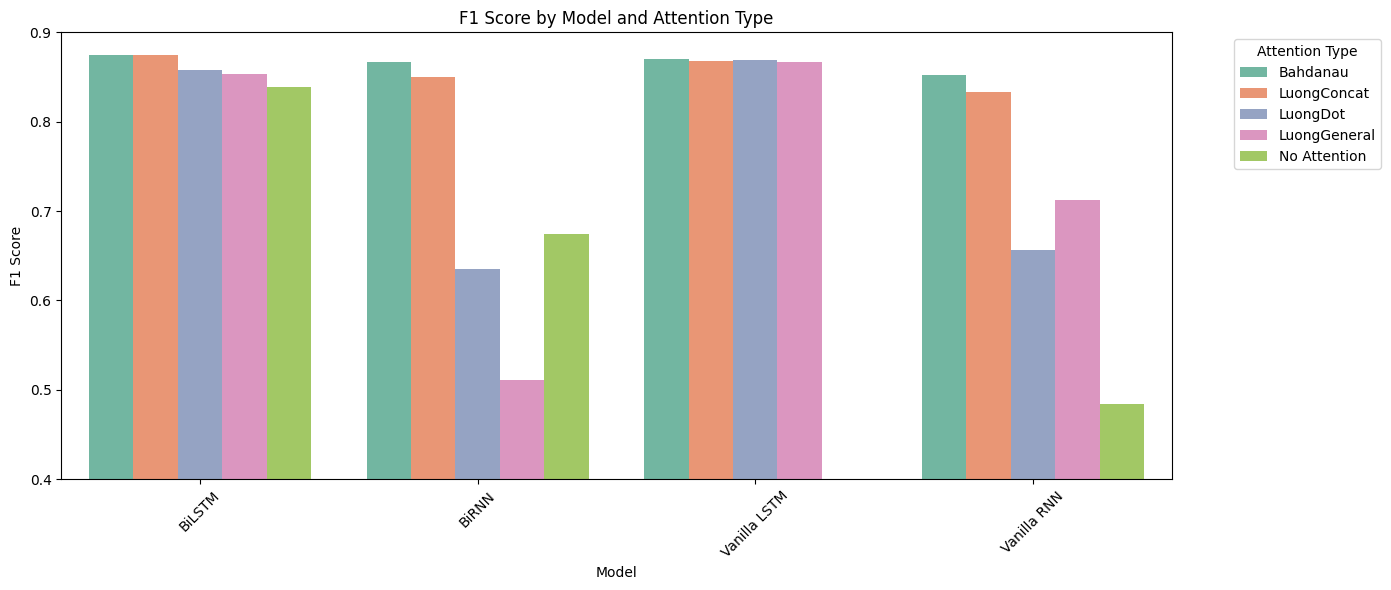

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.barplot(data=df, x="Model", y="f1", hue="Attention", palette="Set2")
plt.title("F1 Score by Model and Attention Type")
plt.ylabel("F1 Score")
plt.ylim(0.4, 0.9)
plt.xticks(rotation=45)
plt.legend(title="Attention Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

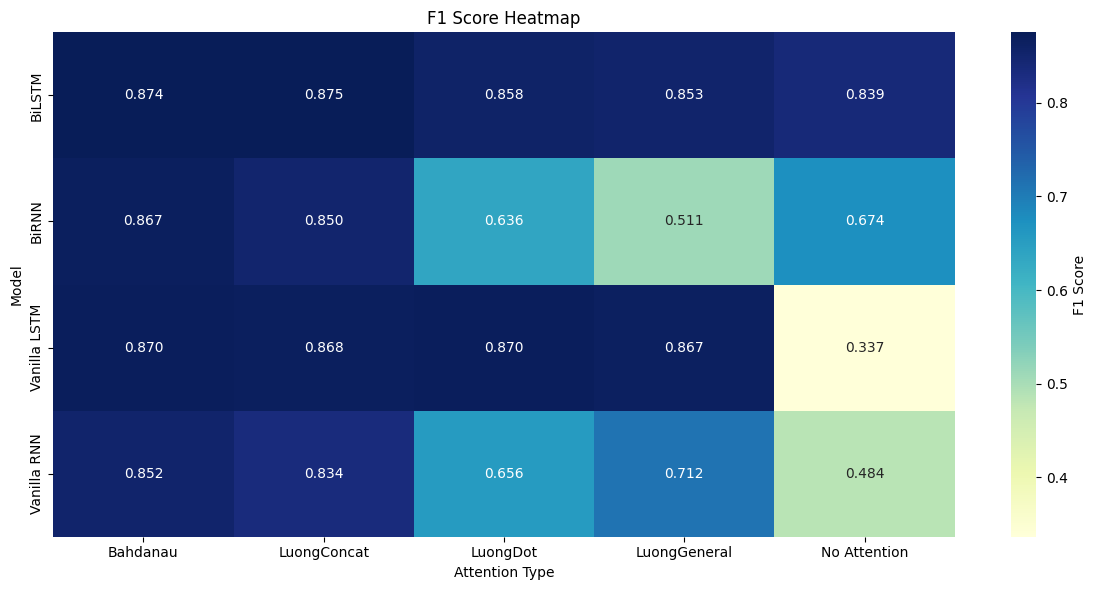

In [32]:
pivot = df.pivot(index="Model", columns="Attention", values="f1")

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'F1 Score'})
plt.title("F1 Score Heatmap")
plt.xlabel("Attention Type")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

In [33]:
df.to_csv("attention_model_results.csv", index=False)